# Building makemore exercise

## E01
> Train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

### Counting

In [1]:
from collections import defaultdict, Counter
import numpy
import torch
from matplotlib import pyplot as plt
import torch.nn.functional as F
from torch.utils.data import random_split

Read in the data

In [2]:
with open('../data/names.txt') as f:
    words = list(map(lambda x: x.strip(), f.readlines()))

In [3]:
words[:10], len(words)

(['emma',
  'olivia',
  'ava',
  'isabella',
  'sophia',
  'charlotte',
  'mia',
  'amelia',
  'harper',
  'evelyn'],
 32033)

In [4]:
def generate_tripling(words):
    for w in words:
        chs = ['.'] + list(w) + ['.']
        for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
            yield ch1, ch2, ch3

In [5]:
alphabets = '.abcdefghijklmnopqrstuvwxyz'
stoi = {char: alphabets.index(char) for char in alphabets}
itos = dict(map(reversed, stoi.items()))

In [6]:
for ch1, ch2, ch3 in generate_tripling(words[:3]): print(ch1, ch2, ch3)

. e m
e m m
m m a
m a .
. o l
o l i
l i v
i v i
v i a
i a .
. a v
a v a
v a .


In [7]:
sum(1 for ch1, ch2, ch3 in generate_tripling(words))

196113

In [8]:
def generate_tripling_counter(words):
    tripling_counter = Counter()
    for ch1, ch2, ch3 in generate_tripling(words):
        tripling_counter[(ch1, ch2, ch3)] += 1
    return tripling_counter    

In [9]:
tripling_counter = generate_tripling_counter(words)
tripling_counter.most_common(10)

[(('a', 'h', '.'), 1714),
 (('n', 'a', '.'), 1673),
 (('a', 'n', '.'), 1509),
 (('o', 'n', '.'), 1503),
 (('.', 'm', 'a'), 1453),
 (('.', 'j', 'a'), 1255),
 (('.', 'k', 'a'), 1254),
 (('e', 'n', '.'), 1217),
 (('l', 'y', 'n'), 976),
 (('y', 'n', '.'), 953)]

In [10]:
len(tripling_counter)

6037

In [11]:
def create_matrix():
    N = torch.zeros((27, 27, 27), dtype=torch.int32)
    for ch1, ch2, ch3 in generate_tripling(words):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        N[ix1, ix2, ix3] += 1
    return N  

In [12]:
N = create_matrix(); N.shape

torch.Size([27, 27, 27])

In [13]:
N[1, 8, 0]

tensor(1714, dtype=torch.int32)

In [14]:
P = (N+1).float()
P = P/P.sum(-1, keepdims=True)

In [15]:
def generate_tripling_prob(words):
    for ch1, ch2, ch3 in generate_tripling(words):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        prob = P[ix1, ix2, ix3]
        yield ch1, ch2, ch3, prob

In [16]:
for ch1, ch2, ch3, prob in generate_tripling_prob(words[:3]): 
    print(ch1, ch2, ch3, prob)

. e m tensor(0.1855)
e m m tensor(0.1269)
m m a tensor(0.3744)
m a . tensor(0.0669)
. o l tensor(0.2494)
o l i tensor(0.1084)
l i v tensor(0.0219)
i v i tensor(0.2669)
v i a tensor(0.1578)
i a . tensor(0.3657)
. a v tensor(0.0550)
a v a tensor(0.1882)
v a . tensor(0.1405)


In [17]:
def generate_names(count, P):
    g = torch.Generator().manual_seed(2147483647)
    for i in range(count):
        out = []
        ix1, ix2 = 0, 0
        while True:
            p = P[ix1, ix2]
            ix1 = ix2
            ix2 = torch.multinomial(p, num_samples = 1, replacement = True).item()
            out.append(itos[ix2])
            if ix2 == 0:
                break
        yield ''.join(out)

In [18]:
for name in generate_names(5, P): print(name)

arrikategase.
rinah.
granataycion.
sakaroserisenebery.
fishagnazise.


In [19]:
def log_likelihood(words):
    sum_log = 0
    count = 0
    for ch1, ch2, ch3, prob in generate_tripling_prob(words):
        sum_log += torch.log(prob)
        count += 1
    return sum_log/count

In [20]:
len(P)

27

In [21]:
log_likelihood(words)

tensor(-2.0927)

negative log likelihood

In [22]:
- log_likelihood(words)

tensor(2.0927)

### NN

In [23]:
def generate_training_set(words):
    xs1 = []
    xs2 = []
    ys = []
    for ch1, ch2, ch3 in generate_tripling(words):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        xs1.append(ix1)
        xs2.append(ix2)
        ys.append(ix3)
    xs1 = torch.tensor(xs1)
    xs2 = torch.tensor(xs2)
    xs = torch.vstack((xs1, xs2)).permute(1, 0)
    ys = torch.tensor(ys)
    return xs, ys 

#### Sample dataset

In [24]:
xs, ys = generate_training_set(words[:1])

In [25]:
xs.shape, ys.shape

(torch.Size([4, 2]), torch.Size([4]))

In [26]:
xenc = F.one_hot(xs, num_classes=27)

In [27]:
xenc.shape

torch.Size([4, 2, 27])

In [28]:
xenc

tensor([[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0]]])

In [29]:
xenc_flattened = xenc.view(4, -1).float()

In [30]:
W = torch.randn((27*2, 27))
W

tensor([[ 0.5918,  1.9446,  0.6062,  ..., -1.3206,  0.7511,  0.2527],
        [-1.1949,  0.5556, -1.8973,  ...,  1.0121,  0.4969, -0.6694],
        [ 1.0155, -0.1593, -1.6470,  ...,  1.7031, -0.8181,  0.5967],
        ...,
        [-0.1382, -0.4184, -0.4411,  ...,  2.3681,  0.7865, -0.6283],
        [-1.9234,  1.1608,  0.1504,  ...,  0.9620,  0.1165,  1.2501],
        [-1.1059,  0.1314,  0.7401,  ..., -0.6660,  0.3437,  0.3428]])

In [31]:
logits = xenc_flattened @ W # log counts

In [32]:
counts = logits.exp()

In [33]:
prob = counts/counts.sum(1, keepdims=True)

In [34]:
prob.shape

torch.Size([4, 27])

In [35]:
ys

tensor([13, 13,  1,  0])

In [36]:
prob[0, 13], prob[1, 13], prob[2, 1], prob[3, 0]

(tensor(0.0144), tensor(0.0226), tensor(0.0070), tensor(0.0114))

In [37]:
-prob[torch.arange(4), ys].log().mean()

tensor(4.3695)

#### Train

In [38]:
xs, ys = generate_training_set(words)

In [39]:
xs[0], ys[0]

(tensor([0, 5]), tensor(13))

In [40]:
xenc = F.one_hot(xs, num_classes=27)
xenc_flattened = xenc.view(len(xenc), -1).float()

In [41]:
xenc_flattened.dtype

torch.float32

In [42]:
xenc_flattened.shape, ys.shape

(torch.Size([196113, 54]), torch.Size([196113]))

In [43]:
def train(X, y, epochs, lr):
    num = X.shape[0]
    print(num)
    W = torch.randn((54, 27), requires_grad=True)
    for i in range(epochs):
        logits = X @ W
        counts = logits.exp()
        prob = counts/counts.sum(1, keepdims=True)
        loss = -prob[torch.arange(num), y].log().mean()
        print(f'Epoch {i} Loss {loss}')
        
        W.grad = None
        loss.backward()
        W.data += -lr * W.grad 
    return W

In [44]:
xenc_flattened.shape[0]

196113

In [45]:
model = train(xenc_flattened, ys, 100, 50)

196113
Epoch 0 Loss 4.1442413330078125
Epoch 1 Loss 3.346977949142456
Epoch 2 Loss 3.018693208694458
Epoch 3 Loss 2.8423268795013428
Epoch 4 Loss 2.7360618114471436
Epoch 5 Loss 2.662476062774658
Epoch 6 Loss 2.6076130867004395
Epoch 7 Loss 2.564934492111206
Epoch 8 Loss 2.5307819843292236
Epoch 9 Loss 2.502955198287964
Epoch 10 Loss 2.4798882007598877
Epoch 11 Loss 2.4604790210723877
Epoch 12 Loss 2.4438893795013428
Epoch 13 Loss 2.4295241832733154
Epoch 14 Loss 2.416940212249756
Epoch 15 Loss 2.4058218002319336
Epoch 16 Loss 2.3959274291992188
Epoch 17 Loss 2.3870749473571777
Epoch 18 Loss 2.3791158199310303
Epoch 19 Loss 2.3719310760498047
Epoch 20 Loss 2.3654189109802246
Epoch 21 Loss 2.359494924545288
Epoch 22 Loss 2.3540847301483154
Epoch 23 Loss 2.3491265773773193
Epoch 24 Loss 2.3445656299591064
Epoch 25 Loss 2.3403568267822266
Epoch 26 Loss 2.3364596366882324
Epoch 27 Loss 2.33284068107605
Epoch 28 Loss 2.32947039604187
Epoch 29 Loss 2.326323986053467
Epoch 30 Loss 2.323379993

Here the loss is less, it is an improve over bigram model

In [46]:
xenc = F.one_hot(torch.tensor([0, 0]), num_classes=27).float()

In [47]:
xenc.shape

torch.Size([2, 27])

### Prediction

In [48]:
def generate_words():
    for i in range(5):
        out = []
        ix1, ix2 = 0, 0
        while True:
            xenc = F.one_hot(torch.tensor([ix1, ix2]), num_classes=27).float()
            xenc_flattened = xenc.view(1, -1)
            logits = xenc_flattened @ model # predict log-counts
            counts = logits.exp()
            p = counts/counts.sum(1, keepdims=True)
            ix1 = ix2
            ix2 = torch.multinomial(p, num_samples=1, replacement=True).item()
            out.append(itos[ix2])
            if ix2 == 0:
                break
        print(''.join(out))

In [49]:
generate_words()

inaer.
relan.
aharmin.
rangezoreni.
soblaynztyantreek.


## E02
> split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

In [50]:
xenc_num = xenc_flattened.shape[0]

In [51]:
range(xenc_num)

range(0, 196113)

In [52]:
test_subset, valid_subset, train_subset = random_split(range(xenc_num), [0.1, 0.1, 0.8], 
                          generator=torch.Generator().manual_seed(42))

In [53]:
train_idx = torch.tensor(train_subset)
valid_idx = torch.tensor(valid_subset)
test_idx = torch.tensor(test_subset)

In [54]:
train_idx.shape, valid_idx.shape, test_idx.shape

(torch.Size([156890]), torch.Size([19611]), torch.Size([19612]))

In [55]:
x_train, y_train = xenc_flattened[train_idx], ys[train_idx]
x_valid, y_valid = xenc_flattened[valid_idx], ys[valid_idx]
x_test, y_test = xenc_flattened[test_idx], ys[test_idx]

In [56]:
model_trigram = train(x_train, y_train, 100, 10)

156890
Epoch 0 Loss 4.329584121704102
Epoch 1 Loss 4.115895748138428
Epoch 2 Loss 3.9307005405426025
Epoch 3 Loss 3.769378185272217
Epoch 4 Loss 3.6298155784606934
Epoch 5 Loss 3.510538339614868
Epoch 6 Loss 3.4096288681030273
Epoch 7 Loss 3.324439764022827
Epoch 8 Loss 3.2519874572753906
Epoch 9 Loss 3.1894969940185547
Epoch 10 Loss 3.134709358215332
Epoch 11 Loss 3.0859360694885254
Epoch 12 Loss 3.0419788360595703
Epoch 13 Loss 3.002005100250244
Epoch 14 Loss 2.9654324054718018
Epoch 15 Loss 2.9318366050720215
Epoch 16 Loss 2.900892496109009
Epoch 17 Loss 2.8723373413085938
Epoch 18 Loss 2.845947504043579
Epoch 19 Loss 2.8215296268463135
Epoch 20 Loss 2.798907995223999
Epoch 21 Loss 2.7779269218444824
Epoch 22 Loss 2.7584407329559326
Epoch 23 Loss 2.740318775177002
Epoch 24 Loss 2.7234408855438232
Epoch 25 Loss 2.707695245742798
Epoch 26 Loss 2.6929824352264404
Epoch 27 Loss 2.6792101860046387
Epoch 28 Loss 2.6662957668304443
Epoch 29 Loss 2.6541638374328613
Epoch 30 Loss 2.642745733

Loss on the dev set

In [102]:
def evaluate_loss(model, x, y):
    logits = x @ model
    counts = logits.exp()
    pred = counts/counts.sum(1, keepdims=True)
    return - pred[torch.arange(x.shape[0]), y].log().mean().item()

In [103]:
evaluate_loss(model_trigram, x_valid, y_valid)

2.381558656692505

Loss on the test set

In [104]:
evaluate_loss(model_trigram, x_test, y_test)

2.3885393142700195

The loss on test and validation dataset are about the same for the trigram model on the training set.

Same we can for the bigram model that I have computed in `nbs/lecture_notes/02_building_makemore.ipynb`. The validation and test dataset have about the same losses to the training set.

The trigram is better than bigram

### E03
> Use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

In [105]:
def train(X, y, epochs, lr, regularization_param, print_at_every_epoch = False, print_at_last=False):
    num = X.shape[0]
    W = torch.randn((54, 27), requires_grad=True)
    for i in range(epochs):
        logits = X @ W
        counts = logits.exp()
        prob = counts/counts.sum(1, keepdims=True)
        loss = -prob[torch.arange(num), y].log().mean()
        
        # regularization
        regularization_loss = regularization_param * (W **2).mean()
        loss += regularization_loss
        
        if print_at_every_epoch: print(f'Epoch {i} Loss {loss}')
        
        W.grad = None
        loss.backward()
        W.data += -lr * W.grad 
        
    if print_at_last: print(f'Loss {loss}')
    return W, loss.item()

In [110]:
def get_reg_param_trend():
    train_losses = []
    val_losses = []
    reg_params = []

    for reg_param in torch.linspace(0, 10, 100):
        model, train_loss = train(x_train, y_train, 100, 10, reg_param)
        val_loss = evaluate_loss(model, x_valid, y_valid)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        reg_params.append(reg_param)

    return train_losses, val_losses, reg_params

In [111]:
train_losses, val_losses, reg_params = get_reg_param_trend()

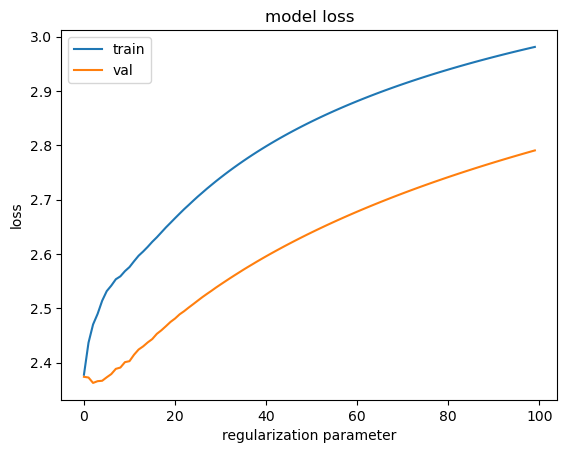

In [112]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('regularization parameter')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### E04
 > We saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

In [ ]:
def train(X, y, epochs, lr, regularization_param, print_at_every_epoch = False, print_at_last=False):
    num = X.shape[0]
    W = torch.randn((54, 27), requires_grad=True)
    for i in range(epochs):
        indices = torch.argmax(X, axis=1)
        logits = W[indices]
        counts = logits.exp()
        prob = counts/counts.sum(1, keepdims=True)
        loss = -prob[torch.arange(num), y].log().mean()
        
        # regularization
        regularization_loss = regularization_param * (W **2).mean()
        loss += regularization_loss
        
        if print_at_every_epoch: print(f'Epoch {i} Loss {loss}')
        
        W.grad = None
        loss.backward()
        W.data += -lr * W.grad 
        
    if print_at_last: print(f'Loss {loss}')
    return W, loss

In [ ]:
train(x_train, y_train, 100, 10, )

In [ ]:
evaluate_loss(x_valid, y_valid)

In [ ]:
evaluate_loss(x_test, y_test)

### E05
> Look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?

In [ ]:
import torch.nn.functional as F

In [ ]:
def train(X, y, epochs, lr, regularization_param, print_at_every_epoch = False, print_at_last=False):
    num = X.shape[0]
    W = torch.randn((54, 27), requires_grad=True)
    for i in range(epochs):
        logits = X @ W
        loss = F.cross_entropy(logits, y)
        
        if print_at_every_epoch: print(f'Epoch {i} Loss {loss}')
        
        W.grad = None
        loss.backward()
        W.data += -lr * W.grad 
        
    if print_at_last: print(f'Loss {loss}')
    return W, loss

In [ ]:
train(x_train, y_train, 100, 10, )

In [ ]:
evaluate_loss(x_valid, y_valid)

In [ ]:
evaluate_loss(x_test, y_test)

### E06
> meta-exercise! Think of a fun/interesting exercise and complete it.